In [1]:
# As usual, a bit of setup
%load_ext autoreload
%autoreload 2
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
from pydatset.mnist import get_data
from pydatset.data_augmentation import *
from res_net import ResNet
from pyfunt.solver import Solver as Solver

from pyfunt.utils.vis_utils import visualize_grid
import matplotlib

%matplotlib inline
#matplotlib.style.use('ggplot')


plt.rcParams['figure.figsize'] = (12.0, 7) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


def moving_average(a, n=200) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
data = get_data('./MNIST/')

data = {
    'X_train': data['X_train'],
    'y_train': data['y_train'],
    'X_val': data['X_test'],
    'y_val': data['y_test'],
}
data['X_train'] = np.pad(data['X_train'], ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant')
data['X_val'] = np.pad(data['X_val'], ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant')

classes = range(10)
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

y_val:  (10000,)
X_val:  (10000, 1, 32, 32)
X_train:  (60000, 1, 32, 32)
y_train:  (60000,)


## Training Input Examples

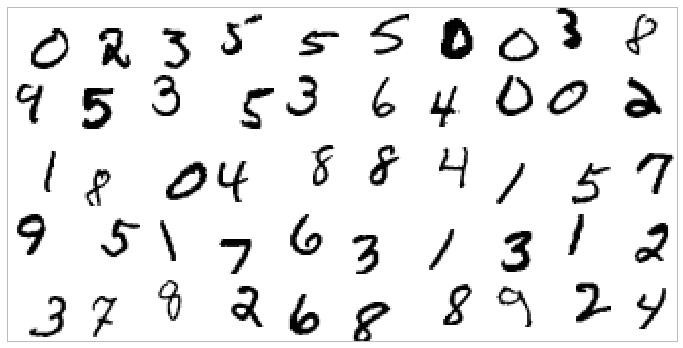

In [3]:

def data_augm(batch):
    p = 4
    h, w = 32, 32
    batch = random_crops(batch, (h, w), pad=6)
    return batch

N = data['X_train'].shape[0]
d = data['X_train'][np.random.randint(N,size=50)]

grid = visualize_grid(data_augm(d).transpose(0, 2, 3, 1), grid_size=(10,5))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.set_xticks([])
ax.set_yticks([])


plt.imshow(1-grid.squeeze())

#plt.savefig('mini_resnet_overfitting_images.png', dpi=100)


#grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))
#plt.imshow(grid.astype('uint8'))

Nsize = 3
Results link: https://drive.google.com/open?id=0B8T8Fw0kS2GbUDk4eEoxSS1CcTA

In [4]:
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick

matplotlib.rcParams.update({'font.size': 13})


def show_all(loss, tr_err, val_err, ylim1=None, ylim2=None):
    fig = plt.figure()
    gs1 = gridspec.GridSpec(2, 1)
    print '## Total training loss and train/ val errors'
    ax = plt.subplot(gs1[0])#2, 1, 1)
    
    
    ax1 = plt.plot(loss)
    plt.setp(ax1, color='#ff4040')
    if ylim1: ax.set_ylim(ylim1)
    plt.ylabel('costo')
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    plt.xlabel('iterazione')

    ax = plt.subplot(gs1[1])#2, 1, 2)
    ax1 = plt.plot(tr_err)
    plt.setp(ax1, color='#ff4040')

    ax1 = plt.plot(val_err)
    
    plt.setp(ax1, color='#104E8B')
    
    if ylim2: ax.set_ylim(ylim2)
    plt.ylabel('errore')
    plt.xlabel('epoca')
    plt.legend(['train', 'val'], loc='upper right')
    gs1.tight_layout(fig)
    
def show_loss(loss, ylim=None):
    print '## Loss'
    ts = pd.DataFrame(loss, columns=['loss'])
    ax = ts.plot()
    if ylim: ax.set_ylim(ylim)
    plt.ylabel('costo')
    plt.xlabel('iterazione')
    
def show_train_val(tr_err, val_err, ylim=None):
    print '## Training and Validation error'
    ts = pd.DataFrame(zip(tr_err, val_err), columns=['train', 'val'])
    ax = ts.plot()
    if ylim: ax.set_ylim(ylim)
    plt.ylabel('errore')
    plt.xlabel('epoca')
    
def show_weights(exp):
    print '## Weights visualization'
    plt.grid(True, color='w', linestyle='-', linewidth=0)
    w = np.load('../Experiments/%s/model.npy' % exp).item()['W1']

    grid = visualize_grid(w.transpose(0, 2, 3, 1))
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    plt.imshow(1-grid.squeeze())
    
    
def show_err_comp(errs, names, losses=None, ylim=None):
    print '## Error Comparision'
    #ts = pd.DataFrame(zip(*errs), columns=names)


    ax = plt.plot(errs[0])
    #ax = ts.plot(style=['-', '--', '-', '--'])
    plt.setp(ax, color='#104E8B', ls='-')
    ax = plt.plot(errs[1])
    plt.setp(ax, color='#104E8B', ls='--')
    ax = plt.plot(errs[2])
    plt.setp(ax, color='#ff4040',ls='-')
    ax = plt.plot(errs[3])
    plt.setp(ax, color='#ff4040',ls='--')
    plt.legend(names, loc='upper right')


    if ylim: ax.set_ylim(ylim)
    plt.ylabel('errore')
    plt.xlabel('epoca')
    plt.show()

        
def show_loss_comp(losses, names, ylim=None):
    print '## Loss'
    ts = pd.DataFrame(zip(*losses), columns=names)
    ax = ts.plot()
    if ylim: ax.set_ylim(ylim)
    plt.ylabel('costo')
    plt.xlabel('iterazione')
    plt.show()
    
    
def show_all_comp(losses, loss_names, errs, err_names, colors, ylim1=False, ylim2=False):
    fig = plt.figure()
    gs1 = gridspec.GridSpec(2, 1)
    print '## Total training loss and train/ val errors'
    ax = plt.subplot(gs1[0])#2, 1, 1)

    for i, loss in enumerate(losses):
        ax1 = plt.plot(loss)
        plt.setp(ax1, color=colors[i % len(colors)])
        
    plt.legend(loss_names, loc='upper right')
    if ylim1: ax.set_ylim(ylim1)
    plt.ylabel('costo')
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    plt.xlabel('iterazione')
    ax1 = plt.subplot(gs1[1])#2, 1, 2)
    
    for i in range(0, len(errs)-1, 2):
        
        ax = plt.plot(errs[i + 0])
        plt.setp(ax, color=colors[i/2], ls='-')
        ax = plt.plot(errs[i + 1])
        plt.setp(ax, color=colors[i/2], ls='--')

    if ylim2: ax1.set_ylim(ylim2)
    plt.ylabel('errore')
    plt.xlabel('epoca')
    plt.show()
    
    
    
def results_for_exp(exp):
    loss = moving_average(np.load('../Experiments/%s/loss.npy' % exp))
    tr_acc = np.loadtxt('../Experiments/%s/train_acc_history.csv' % exp, delimiter=',')[:,-1]
    val_acc = np.loadtxt('../Experiments/%s/val_acc_history.csv' % exp, delimiter=',')[:,-1]
    tr_err = 1 - tr_acc
    val_err = 1 - val_acc
    return loss, tr_err, val_err
    

## Experiment 3b6cf46cd7

Nsize = 3, N starting filters: 8

Results link: https://drive.google.com/open?id=0B8T8Fw0kS2GbUDk4eEoxSS1CcTA

## Total training loss and train/ val errors


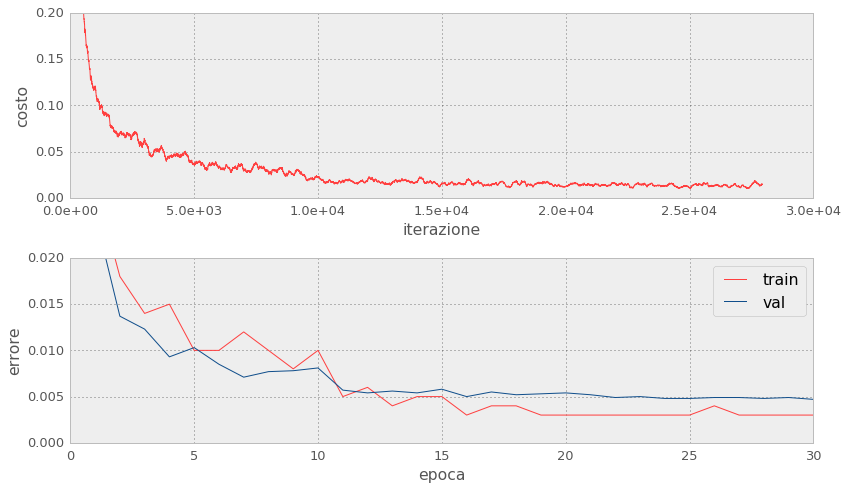

In [5]:
loss, tr_err, val_err = results_for_exp('3b6cf46cd7')
show_all(loss, tr_err, val_err, ylim1=(0.0 ,0.2), ylim2=(0.0, 0.02))

## Weights visualization


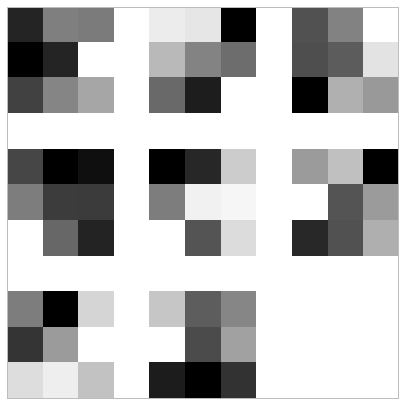

In [6]:
show_weights('3b6cf46cd7')

## Experiment d10407022f

Nsize = 5, N starting filters: 8

Results link: https://drive.google.com/open?id=0B8T8Fw0kS2GbcE9aY2tNUmlCOFU

## Total training loss and train/ val errors


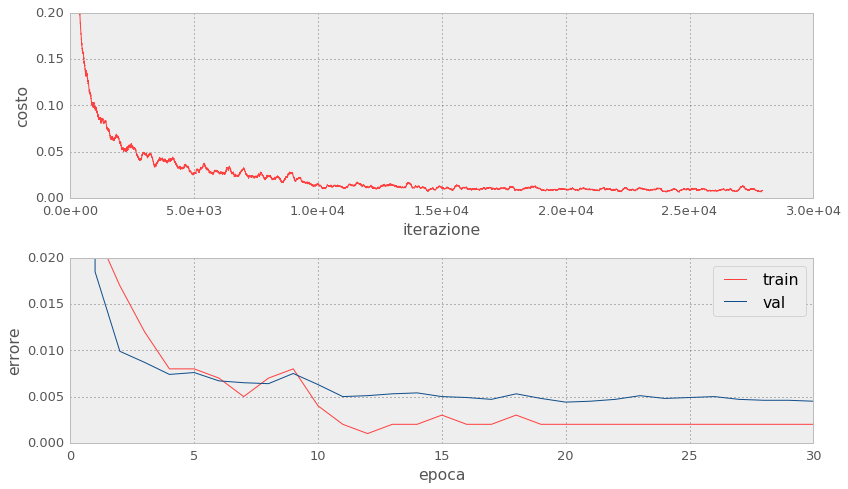

In [7]:
loss, tr_err, val_err = results_for_exp('d10407022f')
show_all(loss, tr_err, val_err, ylim1=(0.0 ,0.2), ylim2=(0.0, 0.02))


## Weights visualization


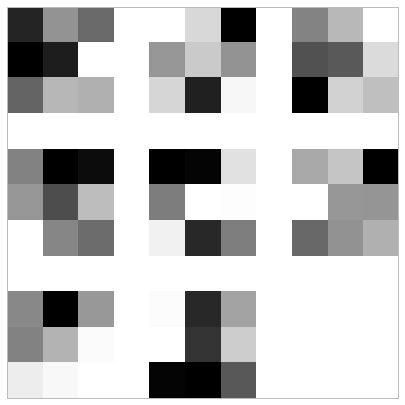

In [8]:
show_weights('d10407022f')

## Total training loss and train/ val errors


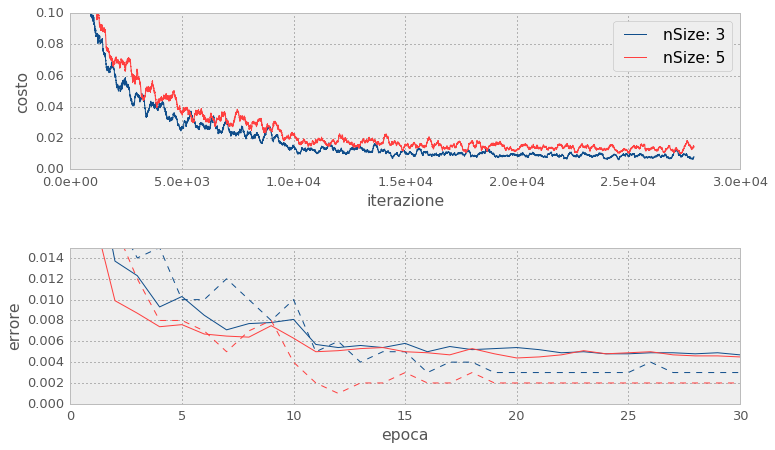

In [9]:
colors = ['#104E8B', '#ff4040']
loss2, tr_err1, val_err1 = results_for_exp('3b6cf46cd7')
loss1, tr_err2, val_err2 = results_for_exp('d10407022f')


#show_loss_comp((loss1, loss2), ['non residual', 'residual'])

losses = (loss1[:len(loss2)], loss2)
losses_names = ('nSize: 3', 'nSize: 5')
errs = (val_err1, tr_err1, val_err2[:120], tr_err2[:120])
err_names = ('1 (val)', '1 (train)',  '3 (val)', '3 (train)')
show_all_comp(losses , losses_names, errs, err_names, colors, ylim1=(0,0.1), ylim2=(0,0.015))

## Experiment 7a0fce8a20

Nsize = 3, N starting filters: 16

## Total training loss and train/ val errors


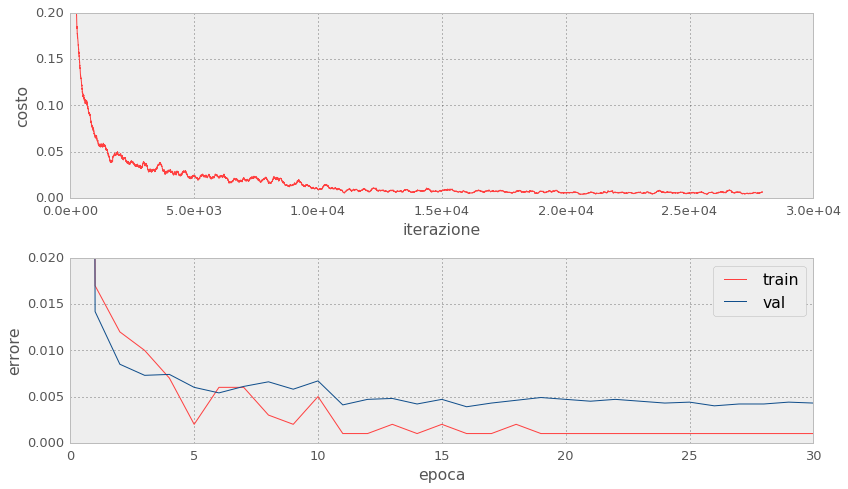

In [10]:
loss, tr_err, val_err = results_for_exp('7a0fce8a20')
show_all(loss, tr_err, val_err, ylim1=(0.0 ,0.2), ylim2=(0.0, 0.02))

## Weights visualization


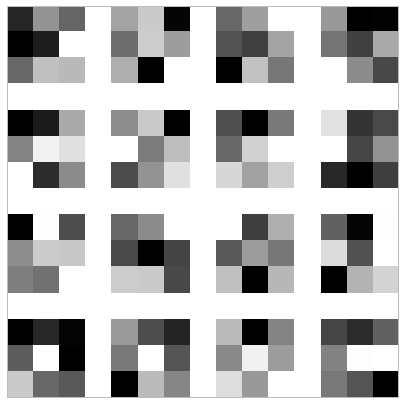

In [11]:
show_weights('7a0fce8a20')

## Total training loss and train/ val errors


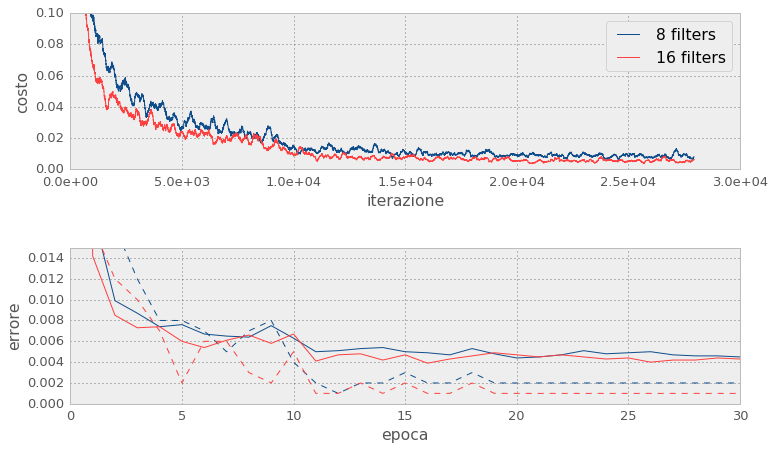

In [12]:
colors = ['#104E8B', '#ff4040']
loss1, tr_err1, val_err1 = results_for_exp('d10407022f')
loss2, tr_err2, val_err2 = results_for_exp('7a0fce8a20')

losses = (loss1[:len(loss2)], loss2)
losses_names = ('8 filters', '16 filters')
errs = (val_err1, tr_err1, val_err2, tr_err2)
err_names = ('1 (val)', '1 (train)',  '3 (val)', '3 (train)')
show_all_comp(losses , losses_names, errs, err_names, colors, ylim1=(0,0.1), ylim2=(0,0.015))

## Total training loss and train/ val errors


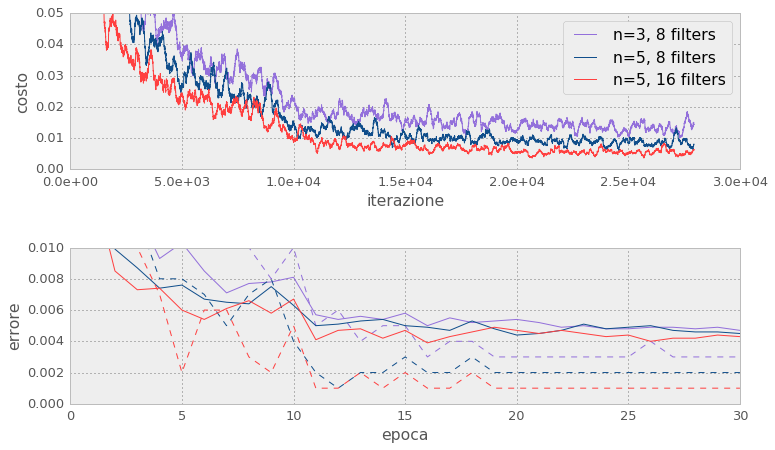

In [14]:
colors = ['#9370DB','#104E8B', '#ff4040']
losses_names = ('n=3, 8 filters', 'n=5, 8 filters', 'n=5, 16 filters')

err_names = ('', '', '1 (val)', '1 (train)',  '3 (val)', '3 (train)')


loss0, tr_err0, val_err0 = results_for_exp('3b6cf46cd7')
loss1, tr_err1, val_err1 = results_for_exp('d10407022f')
loss2, tr_err2, val_err2 = results_for_exp('7a0fce8a20')


#show_loss_comp((loss1, loss2), ['non residual', 'residual'])

losses = (loss0, loss1, loss2)
errs = (val_err0, tr_err0, val_err1, tr_err1, val_err2, tr_err2)
show_all_comp(losses , losses_names, errs, err_names, colors, ylim1=(0,0.05), ylim2=(0,0.010))


In [13]:
# train
exp = '7a0fce8a20'

#grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))

#plt.imshow(grid.astype('uint8'))

res_net = ResNet(5, input_dim=(1, 32, 32),num_starting_filters=16)

solver = Solver(res_net)
solver.model.params = np.load('../Experiments/%s/model.npy' % exp).item()

print data['X_train'].shape
predictions = solver.check_accuracy(data['X_val'], data['y_val'], return_preds=True)

print 'Accuracy: %f' % np.mean(predictions ==  data['y_val'])

Accuracy Check: 100%|██████████| 10000/10000 [03:40<00:00, 45.16im/s]

(60000, 1, 32, 32)

Accuracy: 0.996400


## [Kaggle Competition (5th Place reached)](https://www.kaggle.com/c/digit-recognizer/leaderboard)

The problem with this competition is that it seems that the (train + test) data provided by kaggle is a subset of the MNIST original (train + test) data, which is publicly available (along with the labels for the test set). Basically I trained the netowrk with the original MNIST training set obtaining a validation error (in the experiment 7a0fce8a20) of 0.0039% (99.61% of accuracy) on the original MNIST test set, then I tested with the kaggle's test set and obtained an accuracy of 99.929% (val error of 0.00071%). So obviously I trained the network with many of the kaggle's testing samples and I am somehow a cheater (competition is not ended so the kaggle's results may vary). But the competition is still on course and for now the percentage are evaulated only on a little subset of the test data (25%).


In [14]:
data = get_data('./MNIST/', mode='kaggle')

data = {
    'X_train': data['X_train'],
    'y_train': data['y_train'],
    'X_val': data['X_test'],
    'y_val': data['y_test'],
}
data['X_train'] = np.pad(data['X_train'], ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant')
data['X_val'] = np.pad(data['X_val'], ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant')

classes = range(10)
for k, v in data.iteritems():
    print '%s: ' % k, v.shape if v is not None else None

y_val:  (2000,)
X_val:  (2000, 1, 32, 32)
X_train:  (40000, 1, 32, 32)
y_train:  (40000,)


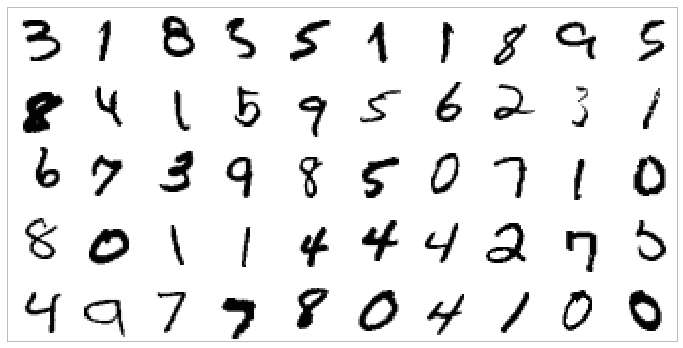

In [15]:
import matplotlib.cm as cm
def data_augm(batch):
    p = 4
    h, w = 32, 32
    batch = random_crops(batch, (h, w), pad=2)
    return batch

N = data['X_train'].shape[0]
d = data['X_train'][np.random.randint(N,size=50)]

grid = visualize_grid(data_augm(d).transpose(0, 2, 3, 1), grid_size=(10,5))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.set_xticks([])
ax.set_yticks([])


plt.imshow(1-grid.squeeze())



In [177]:
# train
exp = '7a0fce8a20'

#grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))

#plt.imshow(grid.astype('uint8'))

res_net = ResNet(5, input_dim=(1, 32, 32),num_starting_filters=16)

solver = Solver(res_net)
solver.model.params = np.load('../Experiments/%s/model.npy' % exp).item()

print data['X_train'].shape
predictions = solver.check_accuracy(data['X_val'], data['y_val'], return_preds=True)

print 'Accuracy: %f' % np.mean(predictions ==  data['y_val'])

Accuracy Check: 100%|██████████| 2000/2000 [00:43<00:00, 47.17im/s]

(40000, 1, 32, 32)

Accuracy: 0.999000


# Appendix

# Visualize Saliency Maps

[original source: http://cs231n.github.io]

Visualize Saliency Maps
In a recent paper [1], it was suggested that you can understand which part of an image is important for classification by visualizing the gradient of the correct class score with respect to the input image. This was covered in lecture on 2/2/2015 under the section "Visualize the data gradient". Recall that if a region of the image has a high data gradient, then this indicates that the output of the ConvNet is sensitive to perturbations in that region of the input image.

We will do something similar, instead visualizing the gradient of the data loss with respect to the input image.

[1] K. Simonyan, A. Vedaldi, A. Zisserman , "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014

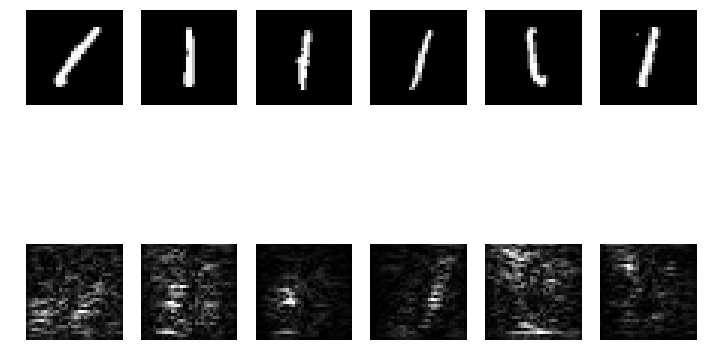

In [181]:
def show_image(img, rescale=False, add_mean=True):
    """
    Utility to show an image. In our ConvNets, images are 3D slices of 4D
    volumes; to visualize them we need to squeeze out the extra dimension,
    flip the axes so that channels are last, add the mean image, convert to
    uint8, and possibly rescale to be between 0 and 255. To make figures
    prettier we also need to suppress the axis labels after imshow.
    
    Input:
    - img: (1, C, H, W) or (C, H, W) or (1, H, W) or (H, W) giving
      pixel data for an image.
    - rescale: If true rescale the data to fit between 0 and 255
    - add_mean: If true add the training data mean image
    """
    img = img.copy()
    if add_mean:
        pass
        #
        #img *= data['std']
        #img += data['mean']
    img = img.squeeze()
    if img.ndim == 3:
        img = img.transpose(1, 2, 0)
    if rescale:
        low, high = np.min(img), np.max(img)
        img = 255.0 * (img - low) / (high - low)
    plt.imshow(img)
    plt.gca().axis('off')

X_val = data['X_val']
y_val = data['y_val']
# The number of example images to show. You can change this.
num_examples = 6

# The label of the class to visualize. You can change this.
class_idx = 1 # 


example_idxs = None

# Choose several examples from the validation set whose correct label is
# class_idx and which are correctly classified by the pretrained ConvNet.
good_points = np.logical_and((predictions == y_val), (y_val == class_idx))
available_idxs, = np.nonzero(good_points)
example_idxs = available_idxs[0:num_examples]


# Compute loss gradients
dX = res_net.loss(X_val[example_idxs], y_val[example_idxs], compute_dX=True, return_probs=False)

# Plot the images and their saliency maps.
for i in xrange(num_examples):
    # Visualize the image
    plt.subplot(2, num_examples, i + 1)
    show_image(X_val[example_idxs[i]])
    #plt.title(class_names[y_val[example_idxs[i]]][0])
    
    # Saliency map for the ith example image.
    sal = np.zeros((32, 32))

    sal = np.max(np.abs(dX[i]), axis = 0)
    
    plt.subplot(2, num_examples, num_examples + i + 1)
    show_image(sal, rescale=True, add_mean=False)

In [158]:
# read test data from CSV file 
test_images = pd.read_csv('./MNIST/test.csv').values
test_images = test_images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0).reshape(-1, 1, 28, 28)
test_images = np.pad(test_images, ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant')

predictions = solver.check_accuracy(test_images, return_preds=True)


Accuracy Check: 100%|██████████| 28000/28000 [13:56<00:00, 47.56im/s]

In [159]:
# save results
np.savetxt('submission_resnet.csv', 
           np.c_[range(1,len(test_images)+1),predictions], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

## Further Notes for Future Experiments with Elastic Distortion

I just implemented a version of the elastic distortion training set augmentation on [PyDatSet](https://github.com/dnlcrl/PyDatSet) based on the code found [here](https://github.com/vsvinayak/mnist-helper/blob/master/mnist_helpers.py), it seems promising and could be applied before the random_crops function at each step, the downside is that it really slowdown the training process, I'll put here the results in case.

Below are some examples of the processed images.

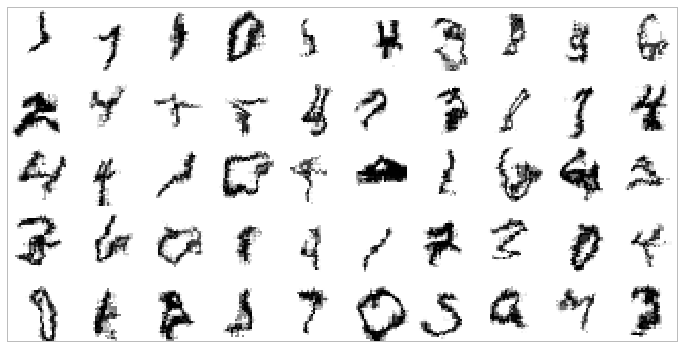

In [185]:
def data_augm(batch):
    p = 4
    h, w = 32, 32
    batch = np.array([elastic_transform(image.reshape(32,32),negated=True) for image in batch]).reshape(-1, 1, 32,32)
        
    batch = random_crops(batch, (h, w), pad=2)
    return batch

N = data['X_train'].shape[0]
d = data['X_train'][np.random.randint(N,size=50)]

grid = visualize_grid(data_augm(d).transpose(0, 2, 3, 1), grid_size=(10,5))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.set_xticks([])
ax.set_yticks([])


plt.imshow(1-grid.squeeze())
